# Dyna-Q+ Comparison
Problem 8.3 - The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa\sqrt{\tau}$ was used not in updates, but solely in action selection. That is, suppose the action selected was always that for which $Q(S_t, a) + \kappa\sqrt{\tau} (S_t, a)$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach.

In [361]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [14]:
# Creating the grid:
# - 0: empty space
# - 1: blocked space
# - 2: start
# - 3: goal
EMTPY = 0
BLOCK = 1
START = 2
GOAL = 3
AGENT = 4

start_pos = 5, 3
goal_pos = 0, 8

grid = np.zeros(shape=(6, 9))
grid[start_pos] = START
grid[goal_pos] = GOAL
grid_blocked_1 = grid.copy()
grid_blocked_2 = grid.copy()

# these are the two grids with large blocks
grid_blocked_1[3, 0:8] = BLOCK
grid_blocked_2[3, 1:9] = BLOCK

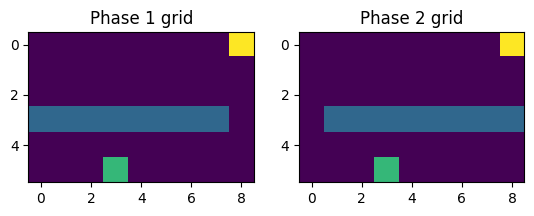

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].imshow(grid_blocked_1)
axs[0].set_title("Phase 1 grid")
axs[1].imshow(grid_blocked_2)
axs[1].set_title("Phase 2 grid")
plt.show()

## Tabular Dyna-Q Algo

<!-- This took ages to write, why is latex such a pain -->
$\text{Initialise }Q(s, a)\text{ and }Model(s,a)\text{ for all }s \in S\text{ and }a \in A(s)\\$
$\text{Loop forever:}\\$
&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow \text{current (nonterminal) state}\\$
&nbsp;&nbsp;&nbsp;&nbsp;$A \leftarrow \epsilon\text{-greedy(S, Q)}\\$
&nbsp;&nbsp;&nbsp;&nbsp;$\text{Take action A; observe }R,\:S'\\$
&nbsp;&nbsp;&nbsp;&nbsp;$Q(S, A) \leftarrow Q(S, A) + \alpha[R + max_a Q(S', a) - Q(S, A)]\\$
&nbsp;&nbsp;&nbsp;&nbsp;$Model(S, A) \leftarrow R, S' \text{ (assuming deterministic environment)}\\$
&nbsp;&nbsp;&nbsp;&nbsp;$\text{Loop repeat n times:}\\$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$S \leftarrow \text{random previously observed state}\\$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$A \leftarrow \text{random action previously taken in S}\\$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$R,\:S' \leftarrow Model(S, A)\\$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q(S, A) \leftarrow Q(S, A) \leftarrow R + max_a Q(S, a) - Q(S, A)\\$

# Standard Dyna-Q

In [363]:
# Now let's implement standard Dyna-Q
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]


n_iter = 3_000
swap_step = 1_000
alpha = 0.05
n_plan = 50
epsilon = 0.05

def select_action(S: tuple, Q: np.ndarray) -> int:
    if np.random.random() < epsilon:
        A = np.random.randint(0, 4)  # 0,1,2,3
    else:
        A = Q[S].argmax()
    return A


def take_action(S: tuple, A: int, grid: np.ndarray) -> tuple[int, tuple]:
    action = actions[A]
    new_y = np.clip(S[0] + action[0], a_min=0, a_max=grid.shape[0] - 1)
    new_x = np.clip(S[1] + action[1], a_min=0, a_max=grid.shape[1] - 1)

    if grid[new_y, new_x] == BLOCK:
        S_prime = S
    else:
        S_prime = (new_y, new_x)

    if S_prime == goal_pos:
        R = 1
    else:
        R = -0.5

    return R, S_prime


def plan_step(visited_state_actions, num_options):
    # pulled into its own function to prevent namespace pollution
    ix = np.random.choice(num_options)
    S = visited_state_actions[0][ix], visited_state_actions[1][ix]
    A = visited_state_actions[2][ix]
    R, S_prime = Model[*S, A]

    S_A = (*S, A)
    R, S_prime = Model[S_A]
    update_val = alpha * (R + Q[S_prime].max() - Q[S_A])
    return S_A,update_val

# Parameters
all_rewards_nm = []
for n_ep in trange(100):
    n_actions = 4
    sa_shape = (*grid.shape, n_actions)
    Q = np.zeros(shape=sa_shape, dtype=float)
    Model = np.zeros(
        shape=sa_shape, dtype=tuple
    )  # a zero in this array indicates that the state hasn't been visited before

    rewards_q = []
    new_start = True

    active_grid = grid_blocked_1
    for iteration in range(n_iter):
        if new_start == True:
            S = start_pos
            new_start = False
        if iteration == swap_step:
            active_grid = grid_blocked_2
        A = select_action(S, Q)
        R, S_prime = take_action(S, A, active_grid)
        S_A = (*S, A)
        Q[S_A] += alpha * (R + Q[S_prime].max() - Q[S_A])
        Model[S_A] = (R, S_prime)

        # if terminated, restart on next iteration
        if R == 1:
            new_start = True
            rewards_q.append(R)
        else:
            rewards_q.append(0)

        S = S_prime

        # get the options before we start the planning step
        visited_state_actions = Model.nonzero()
        num_options = len(visited_state_actions[0])
        for _ in range(n_plan):
            S_A, update_val = plan_step(visited_state_actions, num_options)
            Q[S_A] += update_val
    
    all_rewards_nm.append(rewards_q)

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


In [371]:
def smooth_rewards(all_rewards: list[list]):
    return np.array(all_rewards).cumsum(axis=1).mean(axis=0)

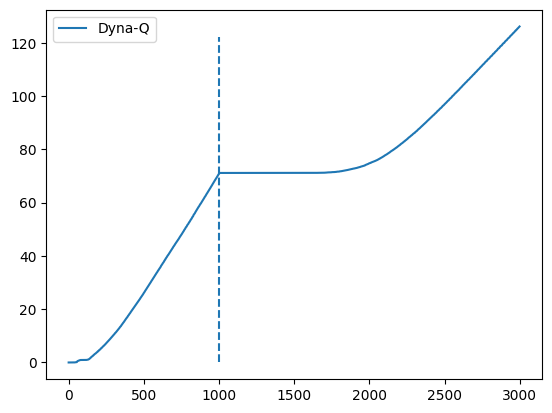

In [372]:
plt.plot(smooth_rewards(all_rewards_nm), label="Dyna-Q")
plt.vlines(swap_step, ymin=0, ymax=sum(rewards_q), linestyles="--")
plt.legend()
plt.show()

# Dyna-Q+

In [373]:
# Now Dyna-Q+ - normally

def plan_step_Qplus(visited_state_actions, num_options):
    # pulled into its own function to prevent namespace pollution
    ix = np.random.choice(num_options)
    S = visited_state_actions[0][ix], visited_state_actions[1][ix]
    A = visited_state_actions[2][ix]
    R, S_prime = Model[*S, A]

    S_A = (*S, A)
    R, S_prime = Model[S_A]
    # Q+ update to R
    R += k * np.sqrt(visit_times[S_A])
    update_val = alpha * (R + Q[S_prime].max() - Q[S_A])
    return S_A,update_val



n_iter = 3_000
swap_step = 1_000
alpha = 0.05
n_plan = 50
epsilon = 0.05
k = 0.01

all_rewards_plus = []
for n_ep in trange(100):
    # Parameters
    n_actions = 4
    sa_shape = (*grid.shape, n_actions)
    Q = np.zeros(shape=sa_shape, dtype=float)
    # a zero in this array indicates that the state hasn't been visited before
    Model = np.zeros(shape=sa_shape, dtype=tuple) 
    visit_times = np.zeros_like(Q, dtype=int)

    rewards_qplus = []
    new_start = True

    active_grid = grid_blocked_1
    for iteration in range(n_iter):
        if new_start == True:
            S = start_pos
            new_start = False
        if iteration == swap_step:
            active_grid = grid_blocked_2
        A = select_action(S, Q)
        R, S_prime = take_action(S, A, active_grid)
        S_A = (*S, A)
        Q[S_A] += alpha * (R + Q[S_prime].max() - Q[S_A])
        Model[S_A] = (R, S_prime)

        # if terminated, restart on next iteration
        if R == 1:
            new_start = True
            rewards_qplus.append(R)
        else:
            rewards_qplus.append(0)

        # Update the visit times
        visit_times += 1
        visit_times[S] = 0
        S = S_prime

        # get the options before we start the planning step
        visited_state_actions = Model.nonzero()
        num_options = len(visited_state_actions[0])
        for _ in range(n_plan):
            S_A, update_val = plan_step_Qplus(visited_state_actions, num_options)
            Q[S_A] += update_val
    
    all_rewards_plus.append(rewards_qplus)

100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


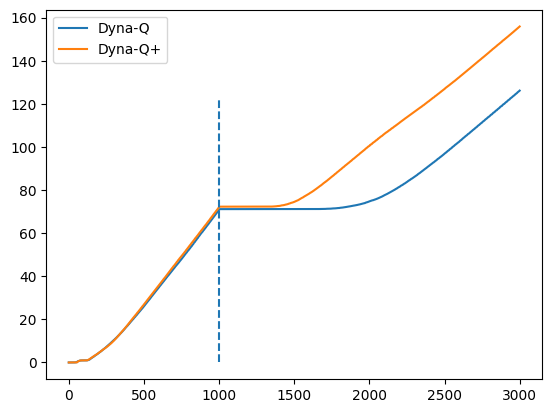

In [374]:
plt.plot(smooth_rewards(all_rewards_nm), label="Dyna-Q")
plt.plot(smooth_rewards(all_rewards_plus), label="Dyna-Q+")
plt.vlines(swap_step, ymin=0, ymax=sum(rewards_q), linestyles="--")
plt.legend()
plt.show()

# Dyna-Q+ Alternative

In [375]:
# Now Dyna-Q+ with the proposed alternative
def select_action_alt(S: tuple, Q: np.ndarray) -> int:
    if np.random.random() < epsilon:
        A = np.random.randint(0, 4)  # 0,1,2,3
    else:
        A = np.argmax(Q[S] + k * np.sqrt(visit_times[S]))
    return A


n_iter = 3_000
swap_step = 1_000
alpha = 0.05
n_plan = 50
epsilon = 0.05
k = 0.01

all_rewards_alt = []
for n_ep in trange(100):
    # Parameters
    n_actions = 4
    sa_shape = (*grid.shape, n_actions)
    Q = np.zeros(shape=sa_shape, dtype=float)
    # a zero in this array indicates that the state hasn't been visited before
    Model = np.zeros(shape=sa_shape, dtype=tuple)
    visit_times = np.zeros_like(Q, dtype=int)

    rewards_qplus_alt = []
    new_start = True

    active_grid = grid_blocked_1
    for iteration in range(n_iter):
        if new_start == True:
            S = start_pos
            new_start = False
        if iteration == swap_step:
            active_grid = grid_blocked_2
        A = select_action_alt(S, Q)
        R, S_prime = take_action(S, A, active_grid)
        S_A = (*S, A)
        Q[S_A] += alpha * (R + Q[S_prime].max() - Q[S_A])
        Model[S_A] = (R, S_prime)

        # if terminated, restart on next iteration
        if R == 1:
            new_start = True
            rewards_qplus_alt.append(R)
        else:
            rewards_qplus_alt.append(0)

        # Update the visit times
        visit_times += 1
        visit_times[S] = 0
        S = S_prime

        # get the options before we start the planning step
        visited_state_actions = Model.nonzero()
        num_options = len(visited_state_actions[0])
        for _ in range(n_plan):
            S_A, update_val = plan_step(visited_state_actions, num_options)
            Q[S_A] += update_val
    all_rewards_alt.append(rewards_qplus_alt)

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


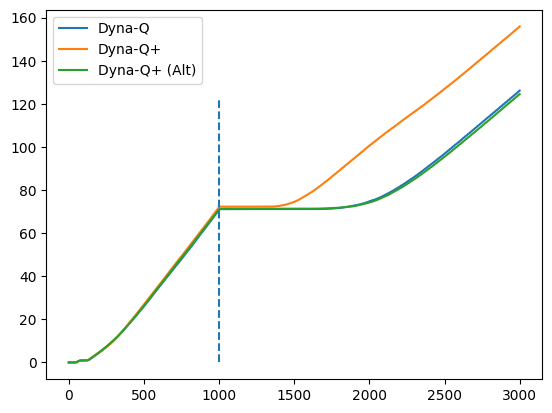

In [376]:
plt.plot(smooth_rewards(all_rewards_nm), label="Dyna-Q")
plt.plot(smooth_rewards(all_rewards_plus), label="Dyna-Q+")
plt.plot(smooth_rewards(all_rewards_alt), label="Dyna-Q+ (Alt)")
plt.vlines(swap_step, ymin=0, ymax=sum(rewards_q), linestyles="--")
plt.legend()
plt.show()

Well it sucks when things get worse - how about when things get better?